In [132]:
import sys, os, re
from operator import itemgetter
import numpy as np
import scipy as sp
import pandas as pd
pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

import sklearn.pipeline as skl_pipeline
import sklearn.preprocessing as skl_preproc
import sklearn.feature_extraction as skl_featext
import sklearn.linear_model as skl_linear
import sklearn.cluster as skl_cluster
import sklearn.decomposition as skl_decomp
import sklearn.model_selection as skl_modsel
import sklearn.metrics as skl_metrics


def plot_dist(x, title, xlabel, ylabel, figsize, log=False):
    '''
    Create a distribution plot.
    '''
    bins = np.arange(0, 6, 1) if log else None
    fig, ax = plt.subplots(figsize=figsize)
    if log:
        log_x = np.log10(x)
        sns.distplot(log_x[~np.isnan(log_x)], bins=bins, kde=False, ax=ax)
        ax.set_xticks(bins)
        ax.set_xticklabels('1e{}'.format(b) for b in bins)
    else:
        sns.distplot(x, bins=bins, kde=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    text = 'min  = {}\nmax = {}'.format(x.min(), x.max())
    ax.text(0.025, 0.975, text, verticalalignment='top', transform=ax.transAxes)
    fig.tight_layout()
    return fig

def plot_bars(x, y, title, xlabel, ylabel, figsize):
    '''
    Create a bar plot.
    '''

    fig, ax = plt.subplots(figsize=figsize)
    x_pos =  np.arange(len(y))
    ax.bar(x_pos, y, align='center', width=0.99, alpha=0.5, color=sns.color_palette()[0])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation=-30)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig


def plot_corr(x, y, title, xlabel, ylabel, figsize):
    '''
    Create a correlation plot.
    '''
    fig, ax = plt.subplots(figsize=figsize)
    sns.regplot(x=x, y=y, ax=ax, fit_reg=False,
                scatter_kws=dict(alpha=0.25, s=2.5))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    xlim = (0, 5000)
    ylim = (-1000, 6000)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.hlines(0, *ax.get_xlim(), linewidth=1.0)
    ax.vlines(0, *ax.get_ylim(), linewidth=1.0)
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', linewidth=0.5)
    mae = skl_metrics.mean_absolute_error(x, y)
    rmse = np.sqrt(skl_metrics.mean_squared_error(x, y))
    r, p = sp.stats.pearsonr(x, y)
    text = 'MAE  = {:.3f}\nRMSE = {:.3f}\nR = {:.3f}, p < {:.3f}'.format(mae, rmse, r, p)
    ax.text(0.025, 0.975, text, verticalalignment='top', transform=ax.transAxes)
    fig.tight_layout()
    return fig


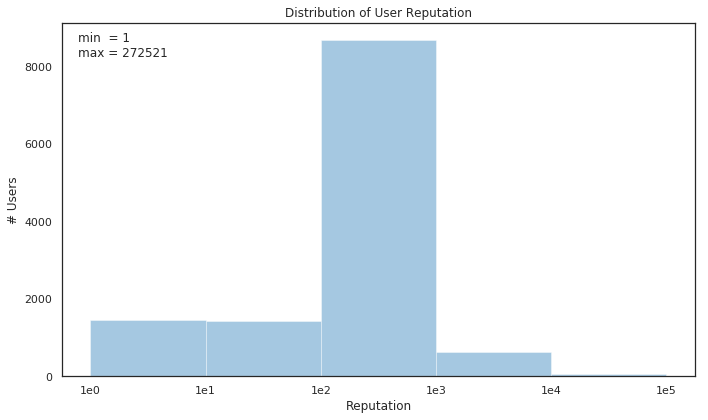

In [92]:
# read relevant data files and create additional transformed features
users = pd.read_csv('csv/Users.csv', index_col=0)
badges = pd.read_csv('csv/Badges.csv', index_col=0)
posts = pd.read_csv('csv/Posts.csv', index_col=0)
comments = pd.read_csv('csv/Comments.csv', index_col=0)

str_len = lambda x: len(x) if isinstance(x, str) else 0
time_since = lambda x: (pd.to_datetime('today') - dt.datetime.strptime(x,
                        '%Y-%m-%dT%H:%M:%S.%f')).total_seconds()

users['DisplayNameLength'] = users['DisplayName'].apply(str_len)
users['AboutMeLength'] = users['AboutMe'].apply(str_len)
users['HasWebsite'] = ~users['WebsiteUrl'].isnull()
users['HasProfileImage'] = ~users['ProfileImageUrl'].isnull()
users['HasAboutMe'] = users['AboutMeLength'] > 0
users['TimeSinceCreate'] = users['CreationDate'].apply(time_since)
users['TimeSinceAccess'] = users['LastAccessDate'].apply(time_since)

user_badges = badges.groupby(['UserId'])
users['NumBadges'] = user_badges.size()
users['NumUniqueBadges'] = user_badges['Name'].nunique()

user_posts = posts.groupby(['OwnerUserId'])
users['NumPosts'] = user_posts.size()
users['MeanPostScore'] = user_posts['Score'].mean()
users['MeanPostViews'] = user_posts['ViewCount'].mean()
users['MeanPostFavorites'] = user_posts['FavoriteCount'].mean()
users['MeanPostComments'] = user_posts['CommentCount'].mean()

user_comments = comments.groupby(['UserId'])
users['NumComments'] = user_comments.size()
users['MeanCommentScore'] = user_comments['Score'].mean()

users['AboutMe'].fillna('', inplace=True)
users.fillna(0, inplace=True)

# plot the distribution of user reputation using a log scale for the bins
fig = plot_dist(users['Reputation'], title='Distribution of User Reputation',
                xlabel='Reputation', ylabel='# Users', figsize=(10,6), log=True)
fig.show()

In [93]:
# set up a predictive model for user reputation using the following user features
numeric_cols = [
    'HasProfileImage',
    'HasWebsite',
    'HasAboutMe',
    'TimeSinceCreate',
    'TimeSinceAccess',
    'Views',
    'UpVotes',
    'DownVotes',
    'NumBadges',
    'NumUniqueBadges',
    'NumPosts',
    'MeanPostScore',
    'MeanPostViews',
    'MeanPostFavorites',
    'MeanPostComments',
    'NumComments',
    'MeanCommentScore'
]
feature_cols = numeric_cols + ['AboutMe']

X = users.loc[:, feature_cols]
y = users.loc[:, 'Reputation']

print('X shape = {}\ny shape = {}'.format(X.shape, y.shape))

model = skl_pipeline.Pipeline([

    # the model has a feature extraction stage followed by a regularized linear regression
    ('feat', skl_pipeline.FeatureUnion([
        ('num', skl_pipeline.Pipeline([
            
            # numeric features can be extended with polynomial combinations, and then standardized
            ('get', skl_preproc.FunctionTransformer(itemgetter(numeric_cols), validate=False)),
            ('poly', skl_preproc.PolynomialFeatures(degree=1, interaction_only=False)),
            ('std', skl_preproc.StandardScaler()),
        ])),
        ('text', skl_pipeline.Pipeline([
            
            # in parallel, tf-idf features are extracted from the user's "about me" string
            ('get', skl_preproc.FunctionTransformer(itemgetter('AboutMe'), validate=False)),
            ('tfidf', skl_featext.text.TfidfVectorizer(max_df=0.5, min_df=2, norm='l2')),
        ]))
    ])),

    # fit a linear regression with some combo of L1 and L2 regularization
    ('reg', skl_linear.ElasticNet(alpha=10.0, l1_ratio=0.5))
])

X shape = (12267, 18)
y shape = (12267,)


In [94]:
# optimize the model with an exhaustive grid search over model params
do_grid_search = False

# caution: this takes a long time and is only included for documentation, it was originally done on a cluster
if do_grid_search:
    
    param_grid = [dict(
        feat__num__poly__degree=[1, 2, 3],
        feat__num__poly__interaction_only=[True, False],
        feat__text__tfidf__max_df=[0.25, 0.5, 1.0],
        feat__text__tfidf__norm=[None, 'l1', 'l2'],
        reg__alpha=[1e-2, 1e-1, 1e0, 1e1, 1e2],
        reg__l1_ratio=[1.0, 0.5, 0.0],
    )]

    def root_mean_squared_error(*args, **kwargs):
        return np.sqrt(skl_metrics.mean_squared_error(*args, **kwargs))

    scoring = dict(
        mae=skl_metrics.make_scorer(skl_metrics.mean_absolute_error),
        rmse=skl_metrics.make_scorer(root_mean_squared_error)
    )

    grid_search = skl_modsel.GridSearchCV(model, param_grid=param_grid, scoring=scoring, refit=False, verbose=10)
    grid_search.fit(X, y)
    search_results = pd.DataFrame(grid_search.cv_results_)
    search_results.sort_values(by='mean_test_mae', inplace=True)
    search_results.to_csv('search_results.csv')

    # select model params that minimize cross-validated mean absolute error
    best_params = search_results.loc[0, 'params']
    model.set_params(**best_params)


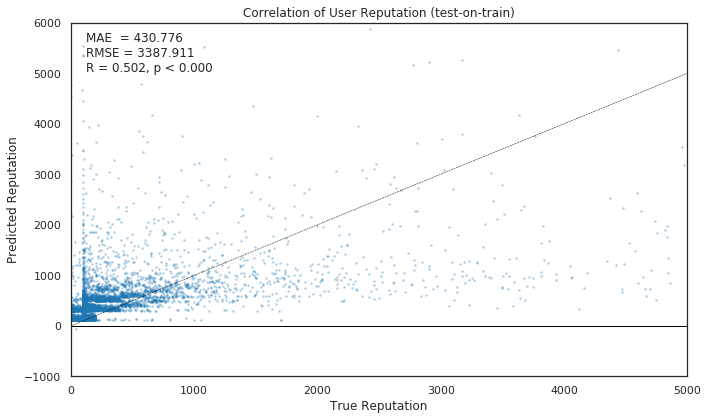

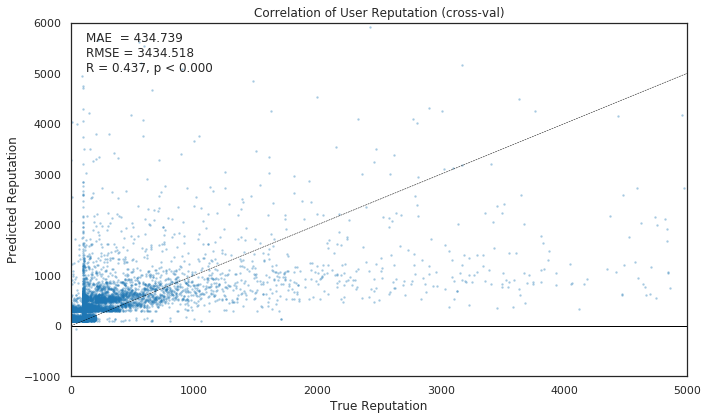

In [95]:
# fit the predictive model with selected params and get both test-on-train and cross-val predictions
model.fit(X, y)
yp_train = model.predict(X)
users['TrainPredReputation'] = yp_train

k_fold = skl_modsel.StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

for train_idx, test_idx in k_fold.split(X, np.log10(y).astype(int)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    yp_test = model.predict(X_test)
    users.loc[users.index[test_idx], 'TestPredReputation'] = yp_test

# plot the reputation predictions against true reputation
fig = plot_corr(users['Reputation'], users['TrainPredReputation'], title='Correlation of User Reputation (test-on-train)',
                xlabel='True Reputation', ylabel='Predicted Reputation', figsize=(10,6))
fig.show()

fig = plot_corr(users['Reputation'], users['TestPredReputation'], title='Correlation of User Reputation (cross-val)',
                xlabel='True Reputation', ylabel='Predicted Reputation', figsize=(10,6))
fig.show()

In [122]:
# set up a topic model for user comments
X = comments.loc[:, 'Text']

print('X shape = {}'.format(X.shape))

# tf-idf features are extracted and then decomposed using non-negative matrix factorization
# the topic model factors the tf-idf feature matrix of size (n_comments, n_features)
#    into two matrices of size (n_topics, n_features) and (n_comments, n_topics)
#    the first describes how much each topic is related to each feature
#    the second decribes how much each comment is related to each topic
model = skl_pipeline.Pipeline([
    ('feat', skl_featext.text.TfidfVectorizer(ngram_range=(1,2), min_df=0.005, max_df=0.1, norm='l2')),
    ('tm', skl_decomp.NMF(n_components=10, random_state=0))
])

X shape = (4502,)


In [123]:
# fit the topic model with the selected parameters
model.fit(X)

feats = model.named_steps['feat'].get_feature_names()
topics = model.named_steps['tm'].components_

X_f = model.named_steps['feat'].transform(X) # comment-feature matrix
X_t = model.named_steps['tm'].transform(X_f) # comment-topic matrix

# print the most-relevant features and comments for each discovered topic
topic_feats = []
for i, topic in enumerate(topics):
    topic_feats.append([feats[j] for j in np.argsort(-topic)[:10]])
    print('Topic {}: '.format(i) + ', '.join(topic_feats[-1]))
    for x in X.iloc[np.argsort(-X_t[:,i])].head(5):
        print('    {}'.format(repr(x)))        
    print
    

Topic 0: of the, one, more, at, all, some, by, from, could, other
    "And to be clear, I'm not disputing that it happens...I generally chalk it up to new users forgetting their credentials and creating a new account though.  I'm just trying to figure out if there's really a problem worth tackling in this specific scenario, and I don't see a vector for abuse yet.  At least not one that's worse than users making useless edits on other's posts to try and gain rep, which has clearly been a problem (cluttering up the active questions screen) from time to time."
    '@CodeInChaos, good advice!  Thanks.  Two caveats: (1) In this case many of the answers already had so many comments that any new comment would have been hidden behind the scroll by default (at least, until others clicked to view all comments and upvoted it).  (2) In some cases, explaining all of the ways the answer could be improved or might be flawed takes more space than available in a single comment.'
    "Instead of leaving

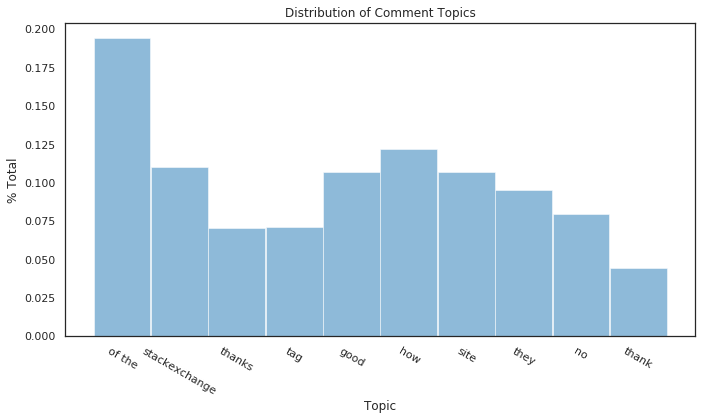

In [135]:
# plot a distribution of the amount of each comment topic as a percentage of the total
topic_labels = zip(*topic_feats)[0]
topic_dist = np.sum(X_t, axis=0)/np.sum(X_t)

fig = plot_bars(topic_labels, topic_dist, title='Distribution of Comment Topics',
                xlabel='Topic', ylabel='% Total', figsize=(10,6))
fig.show()